# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 0.5 < x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

In [37]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [38]:
mutable struct DirectS
  t; x1; x2 ; u ; a ; p1 ; p2 
end

In [39]:
function ZERMELO(x0; solution=[], nsteps=500, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
        x1[1:N+1]                 # x1
        x2[1:N+1]                 # x2
        -π/2 ≤ u[1:N+1] ≤ π/2     # Control
        -π/2 ≤  a       ≤ π/2 
    end)
    
    Δt  =  8.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Max, x1[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]   == x0[1]                #initial condition
        con_x20, x2[1]   == x0[2]                #initial condition
        con_x2f, x2[N+1] == 4.0                  #final condition 
        end)
    
    # Dynamics

    @NLexpression(sys, dx1[j = 1:N+1], ifelse(0.5 < x2[j] < 3.5, x2[j] + cos(a), x2[j] + cos(u[j])))
    
    @NLexpression(sys, dx2[j = 1:N+1], ifelse(0.5 < x2[j] < 3.5, sin(a), sin(u[j])))
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j]) 
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u  = value.(u)[:]
    a  = value.(a)
    t  = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return DirectS(t, x1, x2, u, a, p1, p2)
        
end;
     

In [40]:
# Resolution
x0  = [0.0; 0.0]

sol_direct = ZERMELO(x0);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     1504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      502
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1003
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 9.16e-03  -1.0 0.00e+00    -  0.00e+00

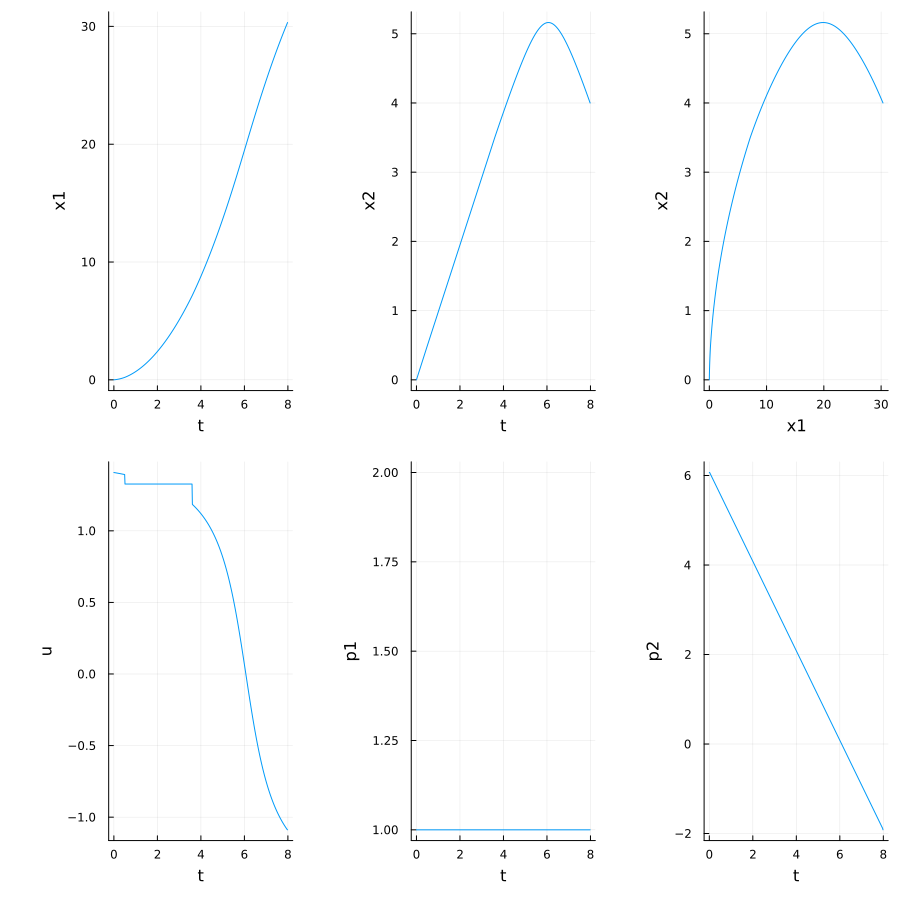

In [41]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
a  = sol_direct.a
p1  = sol_direct.p1
p2  = sol_direct.p2

idx_05 = findall(abs.(x2 .- 0.5) .< 0.01)
idx_35 = findall(abs.(x2 .- 3.5) .< 0.008)


t1 = t[idx_05]
t2 = t[idx_35]


u1 = copy(u) 
u1[t1 .<= t .<= t2] .= a

x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t, p1,  xlabel = "t", ylabel = "p1",  legend = false)
p2_plot   = plot(t, p2,  xlabel = "t", ylabel = "p2",  legend = false)

u_plot    = plot(t, u1,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (2,3), size=(900,900), left_margin=10mm)

# Indirect method

In [42]:
using NLsolve
using Animations
using Reel
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [43]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [ sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region
H2(x, λ, y, p)   = p' * F(x, λ)   + y* p' *G(λ)          # pseudo-Hamiltonian
Hcl(X, P)     = H2(X[1:2], X[3], X[4], P[1:2])           # control loss

# Flows
fcl  = Flow(Hcl);

In [45]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, λ) 
    
    pλ0    = 0.0 
    
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    jump1  = p1[2]*(λ - u11(x1, p1))/(λ - x1[1])           # jump1

    X2, P2 = fcl(tt1, [x1; λ ; 0.0], [p1 - [0. , jump1]; pλ0 ; py0], tt2) # flow augmenté
    
    jump2  = P2[2]*(u11(X2[1:2], P2[1:2]) - λ)/(λ - X2[1]) # jump2
    
    xf, pf = fc(tt2, X2[1:2], P2[1:2] - [0. , jump2], tf)

    s = zeros(eltype(p0), 5)
    s[1]  = xf[2] - x2f # target
    s[2]  = pf[1] - 1.0 # transversality condition
    s[3]  = x1[2] - 0.5 # first crossing 
    s[4]  = X2[2] - 3.5 # second crossing 
    s[5]  = P2[3]       # averaged gradient condition
    return s

end;

In [46]:
S(ξ) = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5]) ;

In [47]:
ξ_guess = [p1[1], p2[1], t1[1], t2[1], a] ; # initial guess

In [48]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[0.49584611599949646, 0.0, 0.0035626399237627115, -0.005973677777743269, -0.24587535761467078]




In [49]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    λ   = indirect_sol.zero[5]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.958461e-01              NaN
     1     2.852736e-03     2.038980e-01
     2     3.629741e-07     1.456172e-03
     3     2.056003e-14     1.512689e-07
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.066602929912969, 0.5109780439121756, 3.592814371257485, 1.3266797807566422]
 * Zero: [1.0, 5.8642245818179015, 0.5078962137988894, 3.59668747270909, 1.33044212754693]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


In [50]:
tt1 - t1[1]

-0.0030818301132862214

In [51]:
tt2 - t2[1]

0.00387310145160491

In [52]:
λ - a 

0.0037623467902878627

In [53]:
using LaTeXStrings

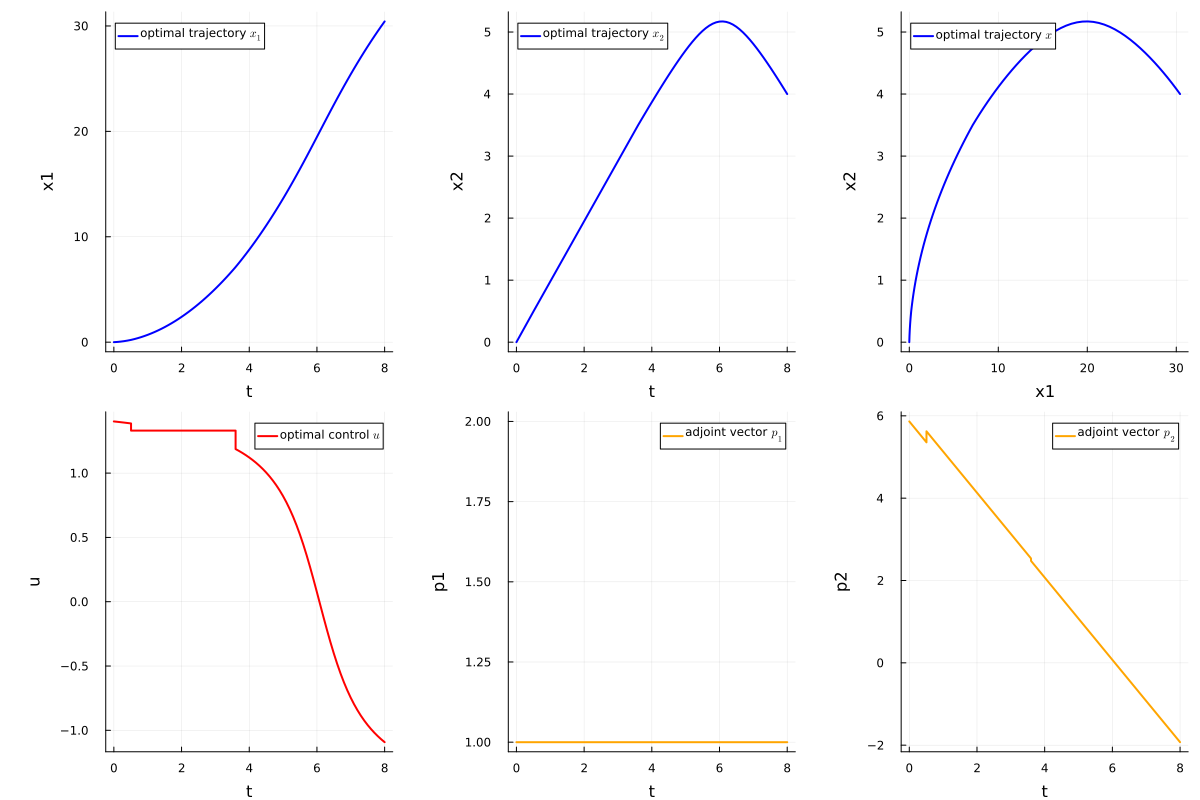

In [72]:
ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = u11.(xx1, pp1)  ;


pλ0 = 0. 
py0 = 0.

v_1     = ode_sol[4, end]*( λ - uu1[end])/(λ - ode_sol[1, end])    # 1st jump condition of the adjoint vector

ode_sol = fcl((tt1, tt2), [xx1[end] ; λ ; 0.0], [pp1[end]- [0. , v_1]; pλ0 ; py0], saveat=0.1)
ttt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2 = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2 = λ.*ones(length(ttt2)) ;

v_2     = ode_sol[6, end]*( uu3[1] - λ)/(λ - ode_sol[1, end])      # 2nd jump condition of the adjoint vector

ode_sol = fc((tt2, tf), xx2[end], pp2[end] - [0. , v_2], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;


t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory $x_1$", linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", label=L"optimal trajectory $x_2$",linecolor=:blue,linewidth=2)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", label=L"adjoint vector $p_1$",linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", label=L"adjoint vector $p_2$",linecolor=:orange,linewidth=2)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   label=L"optimal control $u$",linecolor=:red ,linewidth=2) 
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory $x$", linecolor=:blue,linewidth=2)

x =plot(x1_plot, x2_plot,x1x2_plot,u_plot,p1_plot, p2_plot , layout = (2, 3), size=(1200,800), left_margin=10mm)



In [68]:
# create an animation
#animx = @animate for i = 1:length(t)
#    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(0.,7.), xlabel="x1", ylabel="x2", label="trajectory", linecolor=:blue)
#end

# create an animation
#animu = @animate for i = 1:length(t)
#    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="control", linecolor=:red)
#end ;

In [69]:
# display the animation
#gif(animx, "animationx.gif", fps = 15)

In [70]:
#gif(animu, "animationx.gif", fps = 15)